In [20]:
import torch
import torch.nn.functional as F
from torch import optim

import yaml
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cupy as cp
import gc
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, accuracy_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, classification_report
from sklearn.preprocessing import quantile_transform, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from x_transformers import XTransformer, TransformerWrapper, Decoder, Encoder, ViTransformerWrapper

from aptamer_transformer.model import *
from aptamer_transformer.factories_model_loss import *
from aptamer_transformer.data_utils import *
from aptamer_transformer.dataset import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cfg = read_cfg('../aptamer_transformer/config.yaml')
df = load_df(cfg)

In [3]:
df_filtered = df.copy()
df_filtered.head()

,Sequence,Normalized_Frequency,sum,max,min,count,energy,dot_bracket,strucutre_matrix,Discretized_Frequency
0,AAAAAAAATGGGGGGGGGGGGGGGGGGGGTCTGTTTATTT,0.218865,0.293243,0.071264,0.533216,3,1.000000,........................................,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,AAAAAAACGGCATCGCTAGGCATCAGGTCCCATCCGGTTA,0.465646,0.307381,0.289093,0.621446,3,0.919390,....((.(((.......................))).)).,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,AAAAAAATTGGGGGGGGGGGGGGGGGGGGTCTGTTTATTT,0.301842,0.297997,0.166499,0.597775,3,1.000000,........................................,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,AAAAACAAACCATACAACCCAGACGGCCCGCTGATTTACA,0.398200,0.303517,0.166499,0.712720,3,0.931937,...................(((.((...))))).......,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,AAAAACGCAGCAAACAAGGACCCACGTACGCCCGCATTAT,0.540360,0.316853,0.278974,0.763822,6,0.954282,....(((.................))).............,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [38]:
df_filtered[df_filtered['Normalized_Frequency'] > 0.99]

,Sequence,Normalized_Frequency,sum,max,min,count,energy,dot_bracket,strucutre_matrix,Discretized_Frequency
61157,CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGATG,0.994638,0.87878,0.917585,0.756909,55,0.930711,.(((.(..........).)))((....))............,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
209997,GGGCGGGAGGGAGGGGGGCCACACCAAAACACGTTCAACT,1.000000,1.00000,1.000000,0.736840,66,0.911054,.(((.............)))....................,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [11]:
X = df_filtered['Normalized_Frequency'].values.reshape(-1, 1)
y = df_filtered['energy'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    # "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(),
    # "Support Vector Regression": SVR()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse}, R2: {r2}")

In [4]:
def tokenize_sequence(seq):
    return list(seq)

def tokenize_sequence(seq, max_length, padding_char='N'):
    seq += padding_char * (max_length - len(seq))  # Pad the sequence
    return list(seq)


max_seq_length = max(df_filtered['Sequence'].apply(len))
max_dot_bracket_length = max(df_filtered['dot_bracket'].apply(len))

sequence_tokenized = np.array([tokenize_sequence(seq, max_seq_length) for seq in df_filtered['Sequence']])
dot_bracket_tokenized = np.array([tokenize_sequence(seq, max_dot_bracket_length, '.') for seq in df_filtered['dot_bracket']])

# One-hot encoding the tokenized sequences
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
sequence_encoded = onehot_encoder.fit_transform(sequence_tokenized)
dot_bracket_encoded = onehot_encoder.fit_transform(dot_bracket_tokenized)

# Flatten the encoded arrays
sequence_flattened = sequence_encoded.reshape(df_filtered.shape[0], -1)
dot_bracket_flattened = dot_bracket_encoded.reshape(df_filtered.shape[0], -1)

# Feature 2 - energy
energy = df_filtered['energy'].values.reshape(-1, 1)

# Feature 4 - structure_matrix
max_matrix_size = max(df_filtered['strucutre_matrix'].apply(lambda x: len(x)))
padded_structure_matrix = df_filtered['strucutre_matrix'].apply(
    lambda matrix: np.pad(matrix, (0, max_matrix_size - len(matrix)), mode='constant')
)
structure_matrix = np.array(padded_structure_matrix.tolist())
flattened_structure_matrix = np.array([matrix.flatten() for matrix in structure_matrix])

# Concatenate all features
X = np.hstack((sequence_flattened, dot_bracket_flattened, energy, flattened_structure_matrix))


# Target variable
y_regression = df_filtered['Normalized_Frequency'].values
y_classification = df_filtered['Discretized_Frequency'].values


# Split the dataset into training and testing sets

X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X, y_regression, test_size=0.2, random_state=42)
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(X, y_classification, test_size=0.2, random_state=42)


In [5]:
sequence_flattened.shape, dot_bracket_flattened.shape, energy.shape, flattened_structure_matrix.shape, X.shape, y_regression.shape

((513695, 175),
 (513695, 114),
 (513695, 1),
 (513695, 1681),
 (513695, 1971),
 (513695,))

In [19]:
X_train_regression_gpu = cp.array(X_train_regression)
y_train_regression_gpu = cp.array(y_train_regression)

X_train_classificaion_gpu = cp.array(X_train_classification)
y_train_classificaion_gpu = cp.array(y_train_classification)

In [20]:
model = xgb.XGBRegressor(
    objective='reg:tweedie',
    colsample_bytree=0.7,  # Updated
    learning_rate=0.1,     # Updated
    max_depth=10,          # Updated
    alpha=5,               # Updated
    n_estimators=100,      # Updated
    tree_method='hist',    # Assuming you're still using GPU acceleration
    device='gpu'           # Assuming you're still using GPU acceleration
)

model.fit(X_train_regression_gpu, y_train_regression_gpu)

y_pred = model.predict(X_test)

# R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared: %f" % r2)

R-squared: 0.492425


In [36]:
def get_new_y_class_data(threshold_quantile, df):
    threshold = df['Normalized_Frequency'].quantile(threshold_quantile)
    y_classification = (df['Normalized_Frequency'] >= threshold).astype(int)
    return y_classification

def train_model(model, x_train, y_train):
    model.fit(x_train, y_train)
    return model

def metric_preds(model, x_test, y_test):
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred)
    print(report)
    report = classification_report(y_test, y_pred, output_dict=True)
    return report, y_pred

def return_model():
    xgb_clf = xgb.XGBClassifier(
        objective='binary:logistic',
        colsample_bytree=0.7,  # Updated
        learning_rate=0.1,     # Updated
        max_depth=10,          # Updated
        alpha=5,               # Updated
        n_estimators=100,      # Updated
        tree_method='hist',    # Assuming you're still using GPU acceleration
        device='gpu'
    )
    return xgb_clf

def trial(threshold, df, X):

    y_classification = get_new_y_class_data(threshold, df)
    x_train, x_test, y_train, y_test = train_test_split(X, y_classification, test_size=0.2, random_state=42)
    
    X_train_gpu = cp.array(x_train)
    y_train_gpu = cp.array(y_train)
    
    model = return_model()
    model = train_model(model, X_train_gpu, y_train_gpu)
    report, y_pred = metric_preds(model, x_test, y_test)
    
    gc.collect()
    
    return report, y_pred, y_test

def hyper_parameterize_over_threshold(thresholds, df, X):
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()
    
    reports = {}
    for threshold in thresholds:
        print(f"Threshold: {threshold}")
        mempool.free_all_blocks()
        pinned_mempool.free_all_blocks()
        
        report, y_pred, y_test = trial(threshold, df, X)
        reports[threshold] =  report
        
    return reports
   
thresholds = np.linspace(0.5, 1, 9)
reports = hyper_parameterize_over_threshold(thresholds, df_filtered, X)


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     51021
           1       0.88      0.74      0.80     51718

    accuracy                           0.82    102739
   macro avg       0.83      0.82      0.82    102739
weighted avg       0.83      0.82      0.82    102739

Threshold: 0.5625
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     57524
           1       0.81      0.77      0.79     45215

    accuracy                           0.82    102739
   macro avg       0.82      0.81      0.82    102739
weighted avg       0.82      0.82      0.82    102739

Threshold: 0.625
              precision    recall  f1-score   support

           0       0.85      0.82      0.84     63690
           1       0.73      0.77      0.75     39049

    accuracy                           0.80    102739
   macro avg       0.79      0.80      0.79    102739
weighted avg       0.81 

In [32]:
report, y_pred, y_test = trial(0.99375, df_filtered, X)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    102104
           1       0.73      0.15      0.25       635

    accuracy                           0.99    102739
   macro avg       0.86      0.57      0.62    102739
weighted avg       0.99      0.99      0.99    102739



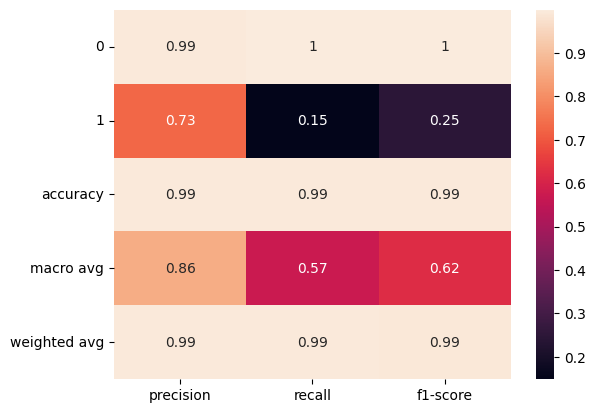

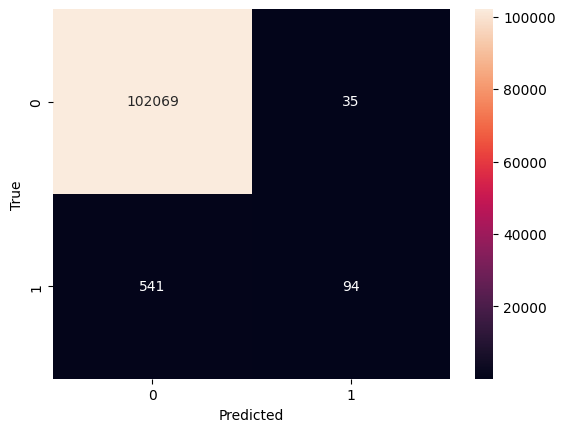

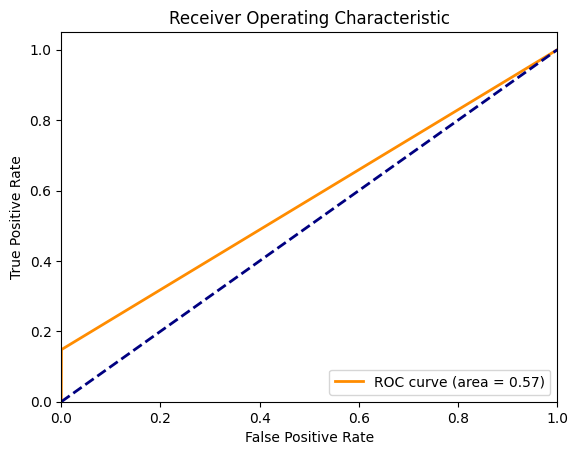

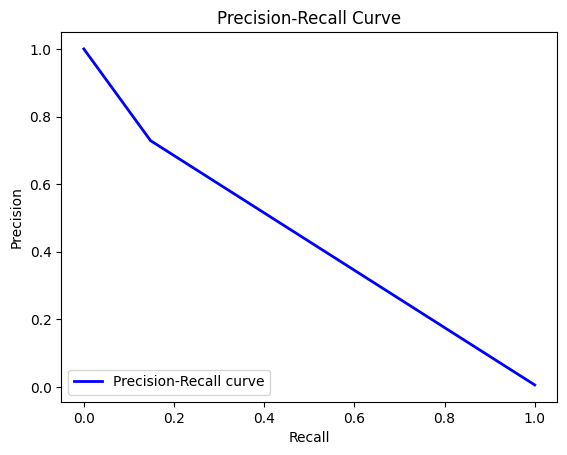

In [35]:

f1 = f1_score(y_test, y_pred, average='binary')  # For binary classification
roc_auc = roc_auc_score(y_test, y_pred)  # y_pred are the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.show()

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [ ]:
search_space = {
    'max_depth': Integer(1, 20),
    'min_child_weight': Integer(0, 20),
    'gamma': Real(0.01, 10, 'log-uniform'),  # Adjusted lower bound
    'subsample': Real(0.1, 1.0),
    'colsample_bytree': Real(0.01, 1.0),
    }


# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device='gpu')

# Initialize the BayesSearchCV object
bayes_cv = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=search_space,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=32,
    n_jobs=-1,
    return_train_score=True,
    random_state=42,
    verbose=5
)

# X_train_numpy = X_train_gpu.get() if isinstance(X_train_gpu, cp.ndarray) else X_train_gpu
# y_train_numpy = y_train_gpu.get() if isinstance(y_train_gpu, cp.ndarray) else y_train_gpu

bayes_cv.fit(X_train, y_train)
# Perform the search

# Print the best parameters and best score
print("Best parameters found: ", bayes_cv.best_params_)
print("Best RMSE found: ", np.sqrt(-bayes_cv.best_score_))

# Evaluate the model with the best parameters
best_model = bayes_cv.best_estimator_
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE on Test Set: %f" % (rmse))

In [ ]:
# Define the parameter grid
param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': [5, 10, 20],
    'alpha': [5, 10, 15],
    'n_estimators': [10, 50, 100]
}

# Initialize the XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device='gpu')

# Initialize Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit Grid Search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)